
# Bagging Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html




In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from tqdm import tqdm
%matplotlib inline

In [63]:

Dp0=pd.read_csv('../datasets/S_MPOS_27_100',delimiter=" ",header=None)
Dn0=pd.read_csv('../datasets/S_MNEG_27_100',delimiter=" ",header=None)

Dp0s=Dp0
Dn0s=Dn0.sample(Dp0s.index.size)
Dn0s=Dn0.sample(2000)


D=pd.concat([Dp0s,Dn0s])
y=np.append(np.zeros([Dp0s.index.size,1]),np.ones([Dn0s.index.size,1]))

#D['strong_feature']=np.random.normal(-.1, .1, y.shape)+y*.2

X=D.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
y

array([0., 0., 0., ..., 1., 1., 1.])

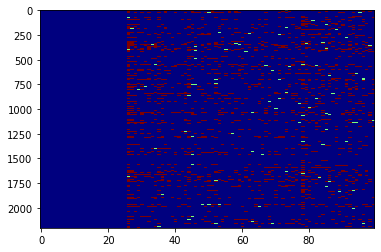

In [64]:
plt.imshow(X,aspect='auto',cmap='jet')

In [65]:
clf_ = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
clf = BaggingClassifier(base_estimator=clf_,n_estimators=10,oob_score=True)


y_pred = clf.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"% (y_test.shape[0],(y_test != y_pred).sum()))

acc=clf.score(X_test,y_test)
y_pred=clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
auc=metrics.auc(fpr, tpr)

print(acc,auc,clf.oob_score_)

Number of mislabeled points out of a total 1102 points : 213
0.8067150635208712 0.5697936643227504 0.7048138056312443


/home/ishanu/.local/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ishanu/.local/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:645: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


In [66]:
clf.estimators_

[DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=1365275795),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=199195755),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=1682535625),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=228324348),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=211714725),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=1728617884),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=1868719011),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=1986143858),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=11760083

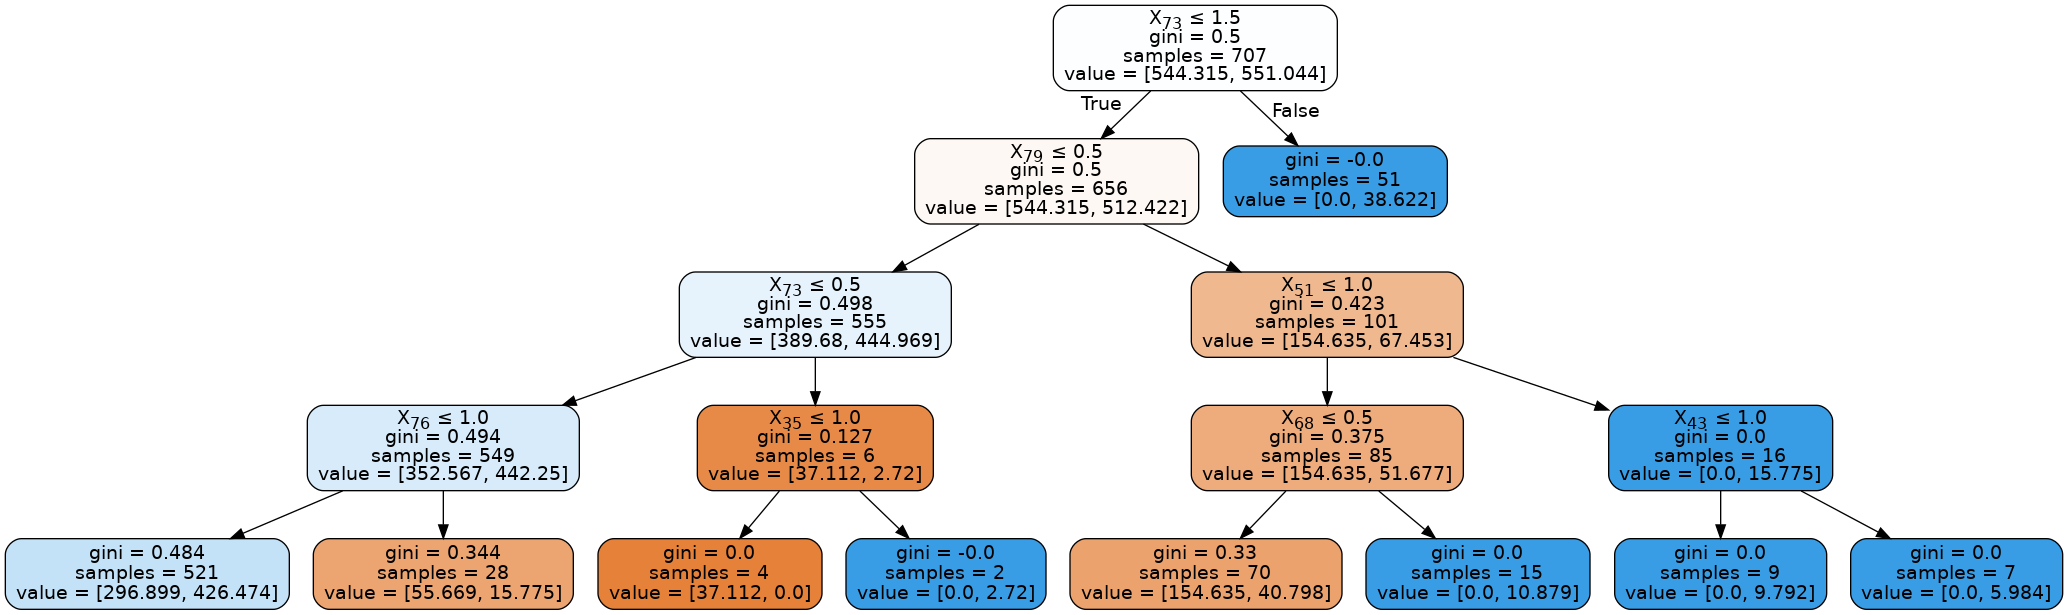

In [67]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from subprocess import call

count=9
dot_data = StringIO()
export_graphviz(clf.estimators_[count], out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
#export_graphviz(clf.estimators_[count], out_file='bagging_tree'+str(count)+'.dot',
#                filled=True, rounded=True,
#                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), width=1900, unconfined=True)

#call(['dot', '-Tpng', 'bagging_tree'+str(count)+'.dot', '-o', 'PSYtree'+str(count)+'.png', '-Gdpi=600'])


/home/ishanu/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ishanu/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


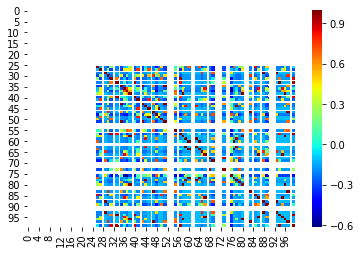

In [68]:
FI={}
count=0
for i in clf.estimators_:
    FI[count]=i.feature_importances_
    count=count+1
FI=pd.DataFrame(FI)
cFI=np.corrcoef(FI.fillna(0).values+0.00001)
sns.heatmap(cFI,cmap='jet')

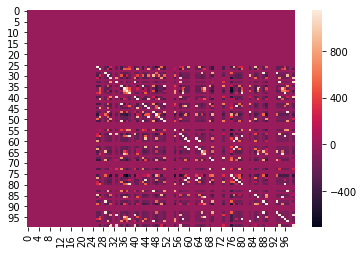

In [69]:
cFI_=pd.DataFrame(cFI).fillna(0)
cFI_.mean().mean()
sns.heatmap(cFI_/cFI_.mean().mean())

In [37]:
# check how much the performance varies by random splits (variance)
RUNS=50
P=[]
for run in tqdm(np.arange(RUNS)):
    clf_ = DecisionTreeClassifier(max_depth=7, class_weight='balanced')
    clf = BaggingClassifier(base_estimator=clf_,n_estimators=40,oob_score=True)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    acc=clf.score(X_test,y_test)
    y_pred=clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
    auc=metrics.auc(fpr, tpr)
    P=np.append(P,[acc,auc])
P=P.reshape(int(len(P)/2),2)

100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


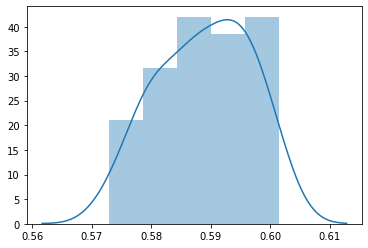

In [38]:
#auc
sns.distplot(P[:,1])

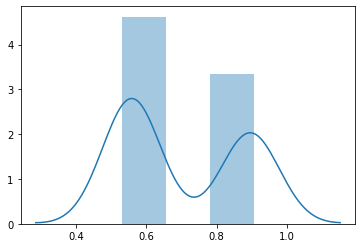

In [39]:
#acc
sns.distplot(P[:,0])

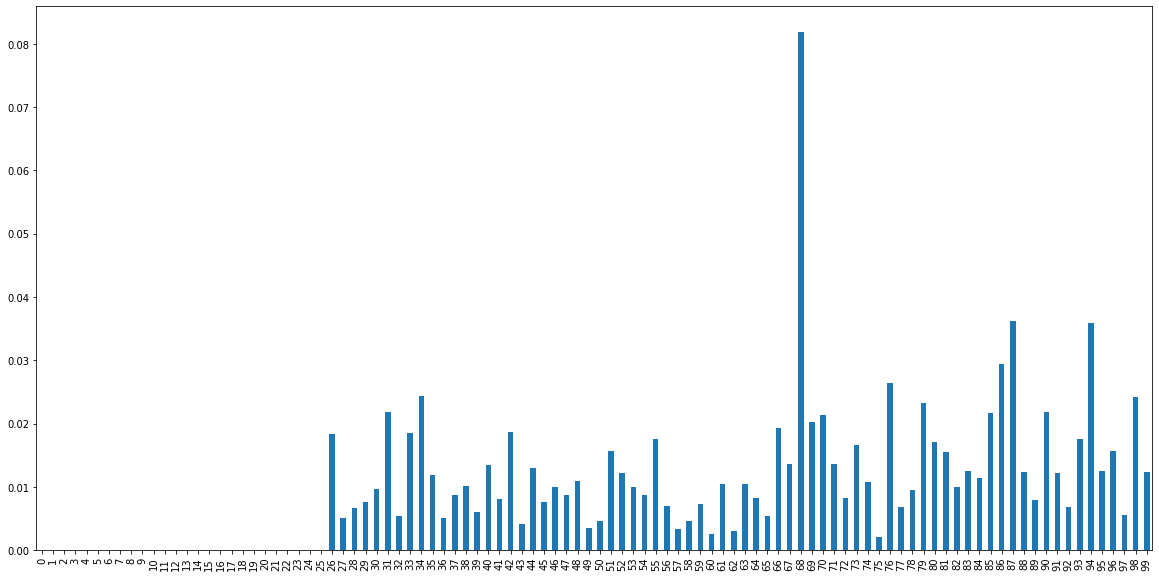

In [41]:
# compute feature importance
plt.figure(figsize=[20,10])
FI={}
count=0
for i in clf.estimators_:
    FI[count]=np.array(i.feature_importances_)
    count=count+1
#FI=FI/len(clf.estimators_)
pd.DataFrame(FI).mean(axis=1).plot(kind='bar')